In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
sns.set_style("whitegrid")

from constants import LOCATION_CHOOSEN, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE, STRINGENCY_BASED_GDP

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

df['date'] = pd.to_datetime(df['date'])
# creating new columns
df['N'] = df['population']
df['S'] = df['population'] - (df['total_cases'] + df['people_fully_vaccinated'])
df['I'] = df['total_cases']
df['R'] = df['people_fully_vaccinated']

In [3]:
print(df.columns)

Index(['Unnamed: 0', 'date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'N', 'S', 'I', 'R', 'S_modelled', 'I_modelled',
       'R_modelled', 'r_eff_actual', 'r_eff_modelled'],
      dtype='object')


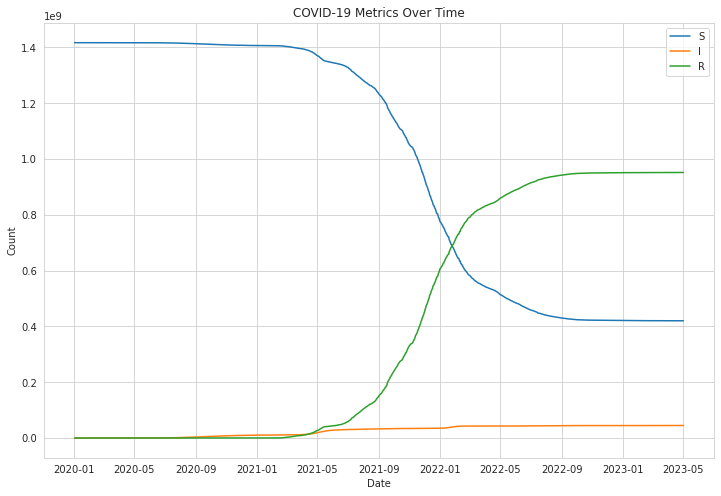

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

## Without Lockdown

In [5]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    n = len(data)
    return (100 / n) * np.sum(np.abs((data - predictions) / data))

def compute_cost(data, predictions):
    return np.sum(np.square(data - predictions))

def compute_cost(data, predictions):
    return np.abs(data - predictions).mean()

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [6]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.07311369954074455 optimal_gamma: 0.044111538344129904
optimal_beta/optimal_gamma: 1.6574733569788114


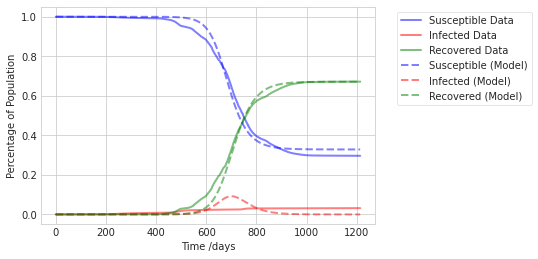

cost_without_lockdown: 74733884.22167633


In [7]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

cost_without_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_without_lockdown: {cost_without_lockdown}")

## With Lockdown

In [8]:
def deriv(y, t, N, beta, gamma, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    n = len(data)
    return (100 / n) * np.sum(np.abs((data - predictions) / data))

def compute_cost(data, predictions):
    return np.sum(np.square(data - predictions))

def compute_cost(data, predictions):
    return np.abs(data - predictions).mean()

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [9]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.30476930289993887 optimal_gamma: 0.07121978800190573
optimal_beta/optimal_gamma: 4.2792784344118475


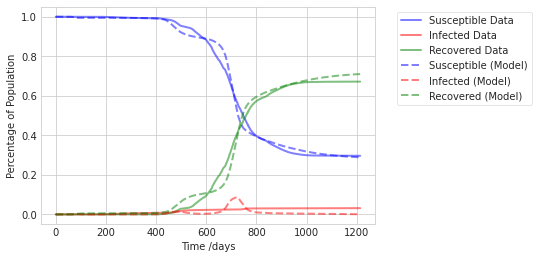

cost_with_lockdown: 71820720.54455066


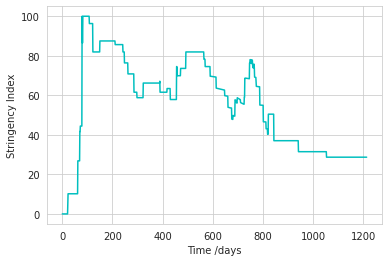

In [10]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, lockdown))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time /days')
plt.ylabel('Stringency Index')
plt.grid(True)

cost_with_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_with_lockdown: {cost_with_lockdown}")

## Decrease in cost by modelling Lockdown

In [11]:
print(f"difference in cost for with/without lockdown: {cost_without_lockdown - cost_with_lockdown}")

difference in cost for with/without lockdown: 2913163.6771256775


In [12]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

In [13]:
print(df.columns)

Index(['Unnamed: 0', 'date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'N', 'S', 'I', 'R', 'S_modelled', 'I_modelled',
       'R_modelled', 'r_eff_actual', 'r_eff_modelled'],
      dtype='object')


In [14]:
r0 = optimal_beta/optimal_gamma

df["S_modelled"] = S
df["I_modelled"] = I
df["R_modelled"] = R
df["r_eff_actual"] = r0 * df["S"]/df["N"]
df["r_eff_modelled"] = r0 * df["S_modelled"]/df["N"]

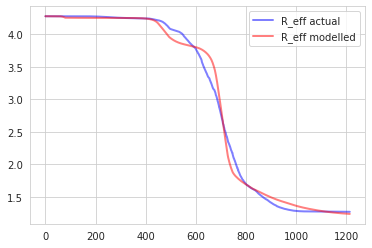

In [15]:
plt.figure()
plt.plot(t, df['r_eff_actual'], 'b', alpha=0.5, lw=2, label='R_eff actual')
plt.plot(t, df['r_eff_modelled'], 'r', alpha=0.5, lw=2, label='R_eff modelled')
plt.legend()

In [16]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

In [17]:
stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

In [18]:
print(max(df['gdp_normalized']), min(df['gdp_normalized']))

df['gdp_min_max_normalized'] = (df['gdp_normalized'] - MIN_GDP) / (MAX_GDP - MIN_GDP)

101.242886554856 83.7288107955639


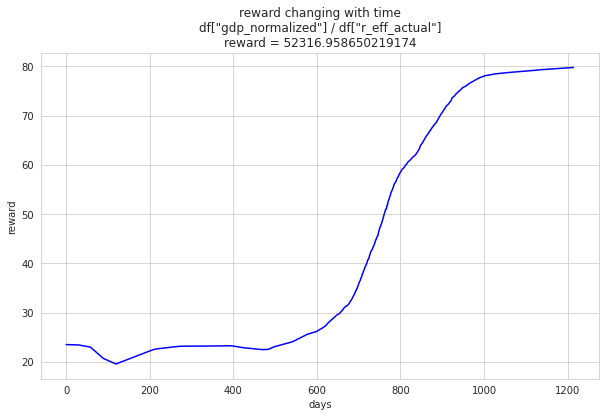

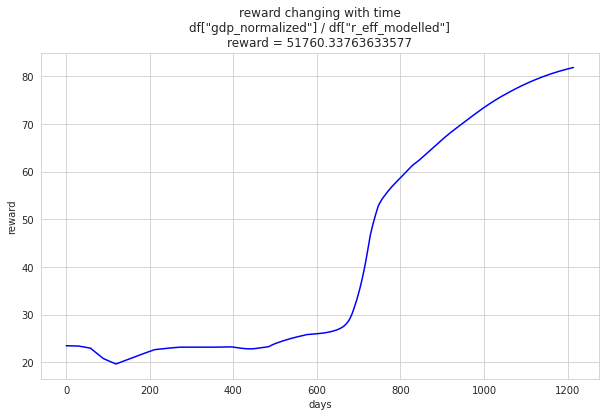

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df['gdp_normalized'] / df['r_eff_actual'], color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_actual"]\nreward = {reward}'.format(reward = np.sum(df['gdp_normalized'] / df['r_eff_actual'])))
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df['gdp_normalized'] / df['r_eff_modelled'], color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_modelled"]\nreward = {reward}'.format(reward = np.sum(df['gdp_normalized'] / df['r_eff_modelled'])))
plt.show()

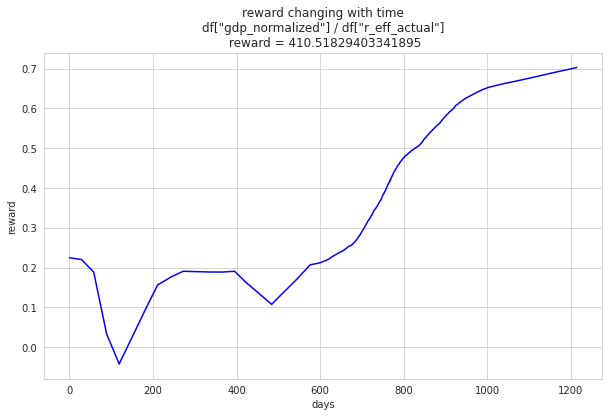

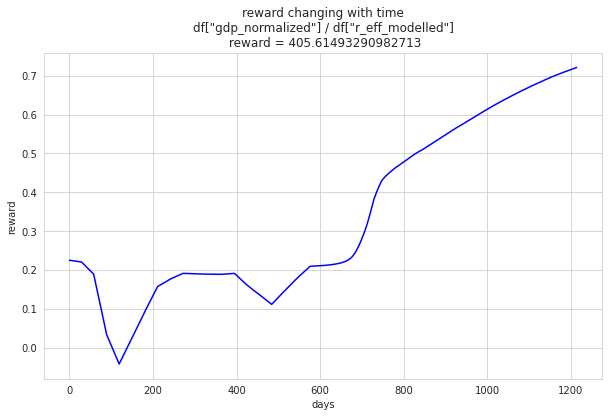

In [20]:
plt.figure(figsize=(10, 6))
reward = df['gdp_min_max_normalized'] / (df['r_eff_actual'] * np.exp(df.index.to_numpy() * 0.0001))
plt.plot(reward, color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_actual"]\n reward = {reward}'.format(reward = np.sum(reward)))
plt.show()

plt.figure(figsize=(10, 6))
reward = df['gdp_min_max_normalized'] / (df['r_eff_modelled'] * np.exp(df.index.to_numpy() * 0.0001))
plt.plot(reward, color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_modelled"]\n reward = {reward}'.format(reward = np.sum(reward)))
plt.show()

In [21]:
df.diff()['stringency_index'][1:].describe()

count    1214.000000
mean        0.023641
std         2.203523
min       -14.360000
25%         0.000000
50%         0.000000
75%         0.000000
max        55.560000
Name: stringency_index, dtype: float64

In [22]:
# try the reward function with our set of steps and see the results:

stringency_moves = []
for i in range(0, days_difference + 1):
    if i < 100:
        stringency_move = 20
    elif i < 200:
        stringency_move = 50
    elif i < 300:
        stringency_move = 70
    elif i < 400:
        stringency_move = 50
    elif i < 500:
        stringency_move = 20
    elif i < 700:
        stringency_move = 10
    else:
        stringency_move = 0
    stringency_moves.append(stringency_move)

stringency_moves = np.array(stringency_moves)
print(stringency_moves)

[20 20 20 ...  0  0  0]


In [23]:
moves_lockdown = stringency_moves / 100
moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, moves_lockdown))
# Get the new S, I, R values
moves_S, moves_I, moves_R = moves_ret.T

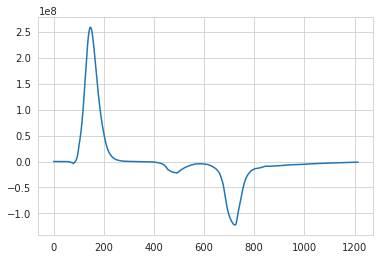

In [24]:
plt.plot(moves_I - df['I_modelled'].values)

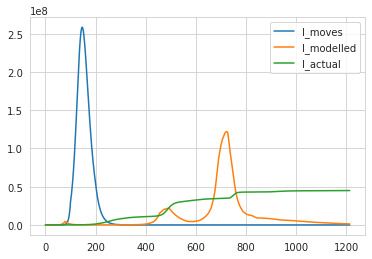

In [25]:
plt.plot(moves_I, label='I_moves')
plt.plot(df['I_modelled'], label='I_modelled')
plt.plot(df['I'], label='I_actual')
plt.legend()

928 1011 179


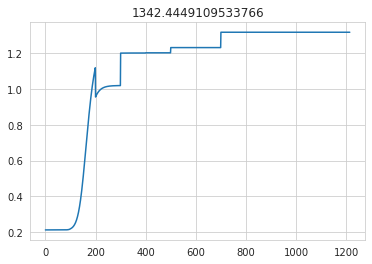

In [30]:
df["r_eff_moves"] = r0 * moves_S/df["N"]
df["gdp_moves_min_max_normalized"] = (fit_line_loaded(stringency_moves) - MIN_GDP) / (MAX_GDP - MIN_GDP)
df['reward_moves'] = df['gdp_moves_min_max_normalized'] / (df['r_eff_moves'])
plt.plot(df['reward_moves'])
plt.title(np.sum(df['reward_moves']))

first_time_r_eff_1_actual = next((t for t, r_eff in zip(df.index, df['r_eff_actual']) if r_eff <= 1.35), None)
first_time_r_eff_1_modelled = next((t for t, r_eff in zip(df.index, df['r_eff_modelled']) if r_eff <= 1.35), None)
first_time_r_eff_1_moves = next((t for t, r_eff in zip(df.index, df['r_eff_moves']) if r_eff <= 1), None)
print(first_time_r_eff_1_actual, first_time_r_eff_1_modelled, first_time_r_eff_1_moves)